# This uses the [ELFI]() demo from [here](https://github.com/elfi-dev/notebooks/blob/master/quickstart.ipynb)

To setup a notebook page in quarto:

* Activate your virtual environment
* Install required libraries (`pip install -r requirements.txt` to use repository's dependencies)
* If you want the user to be able to edit it in binder
    * generate `requirements.txt` in the root of the reporistory directory `pip freeze >requirements.txt` (this will mean Binder picks it up when building the binder image)
    * generate binder link: goto https://mybinder.org/  and fill in repo details and location of notebook
    * paste the generated URL or markdown fragment into the notebook (or wherever)
    * Note that the first time the binder is run it'll take a while, as it has to build the environment and its dependencies.  This is cached, so subsequent runs should be quicker


[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mawds/quarto-binder-python/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fmawds%252Fquarto-tutorial-site%26urlpath%3Dtree%252Fquarto-tutorial-site%252Fpython_tutorials%252Fquickstart.ipynb%26branch%3Dmain)




## Notes

This notebook has `code-fold: true` to hide code by default; we can override this on a cell by cell basis with the special `#|` comment, e.g. `#|code-fold: false`.

This page lists the options we can apply to each cell: https://quarto.org/docs/reference/cells/cells-jupyter.html



# Quickstart

First ensure you have [installed](http://elfi.readthedocs.io/en/stable/installation.html) Python 3.5 (or greater) and ELFI. After installation you can start using ELFI:

In [15]:
import elfi

ELFI includes an easy to use generative modeling syntax, where the generative model is specified as a directed acyclic graph (DAG). Let’s create two prior nodes:

> we use the code-fold option discussed above, so the user can always see this code

In [16]:
#| code-fold: false
mu = elfi.Prior('uniform', -2, 4)
sigma = elfi.Prior('uniform', 1, 4)

The above would create two prior nodes, a uniform distribution from -2 to 2 for the mean `mu` and another uniform distribution from 1 to 5 for the standard deviation `sigma`. All distributions from `scipy.stats` are available.

For likelihood-free models we typically need to define a simulator and summary statistics for the data. As an example, lets define the simulator as 30 draws from a Gaussian distribution with a given mean and standard deviation. Let's use mean and variance as our summaries:

In [17]:
import scipy.stats as ss
import numpy as np

def simulator(mu, sigma, batch_size=1, random_state=None):
    mu, sigma = np.atleast_1d(mu, sigma)
    return ss.norm.rvs(mu[:, None], sigma[:, None], size=(batch_size, 30), random_state=random_state)

def mean(y):
    return np.mean(y, axis=1)

def var(y):
    return np.var(y, axis=1)

Let’s now assume we have some observed data `y0` (here we just create some with the simulator):

In [18]:
# Set the generating parameters that we will try to infer
mean0 = 1
std0 = 3

# Generate some data (using a fixed seed here)
np.random.seed(20170525) 
y0 = simulator(mean0, std0)
print(y0)

[[ 3.7990926   1.49411834  0.90999905  2.46088006 -0.10696721  0.80490023
   0.7413415  -5.07258261  0.89397268  3.55462229  0.45888389 -3.31930036
  -0.55378741  3.00865492  1.59394854 -3.37065996  5.03883749 -2.73279084
   6.10128027  5.09388631  1.90079255 -1.7161259   3.86821266  0.4963219
   1.64594033 -2.51620566 -0.83601666  2.68225112  2.75598375 -6.02538356]]


Now we have all the components needed. Let’s complete our model by adding the simulator, the observed data, summaries and a distance to our model:

In [19]:
# Add the simulator node and observed data to the model
sim = elfi.Simulator(simulator, mu, sigma, observed=y0)

# Add summary statistics to the model
S1 = elfi.Summary(mean, sim)
S2 = elfi.Summary(var, sim)

# Specify distance as euclidean between summary vectors (S1, S2) from simulated and
# observed data
d = elfi.Distance('euclidean', S1, S2)

If you have `graphviz` installed to your system, you can also visualize the model:

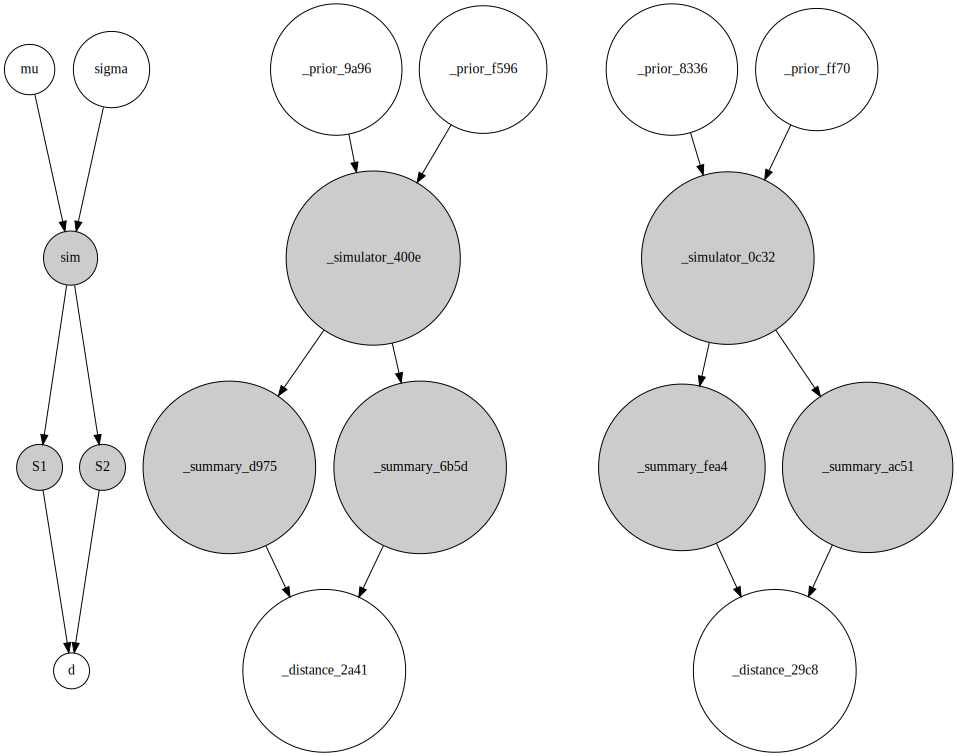

In [20]:
# Plot the complete model (requires graphviz)
elfi.draw(d)

We can try to infer the true generating parameters `mean0` and `std0` above with any of ELFI’s inference methods. Let’s use ABC Rejection sampling and sample 1000 samples from the approximate posterior using threshold value 0.5:

In [21]:
rej = elfi.Rejection(d, batch_size=10000, seed=30052017)
res = rej.sample(1000, threshold=.5)
print(res)

Progress [==================================================] 100.0% Complete
Method: Rejection
Number of samples: 1000
Number of simulations: 130000
Threshold: 0.481
Sample means: _prior_8336: 0.718, _prior_9a96: -0.0234, _prior_f596: 3, _prior_ff70: 3.12, mu: 0.00722, sigma: 3.01



Let's plot also the marginal distributions for the parameters:

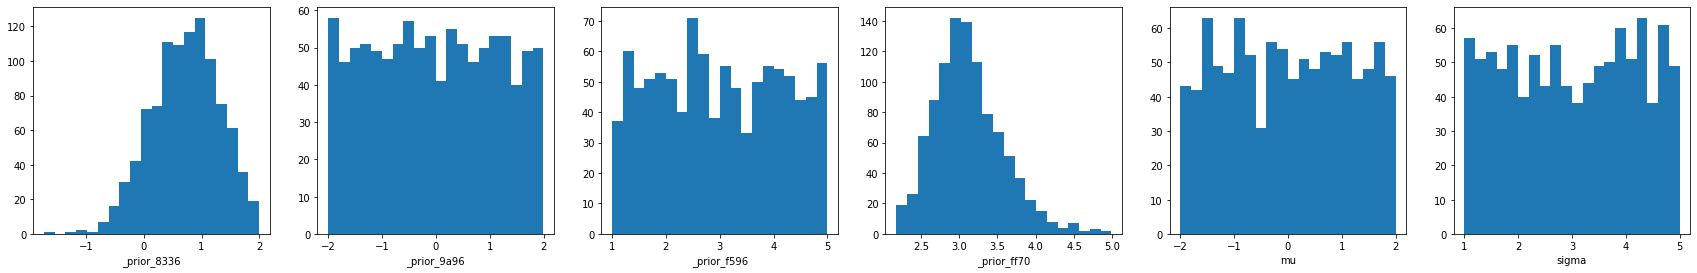

In [22]:
import matplotlib.pyplot as plt
res.plot_marginals()
plt.show()